In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

# Logistic Regression

This is the notebook accompanies the lecture on Logistic Regression.

Notebook created by [Joseph E. Gonzalez](https://eecs.berkeley.edu/~jegonzal) for DS100.

# Real Data

For this lecture we will use the Wisconsin Breast Cancer Dataset which we can obtain from [scikit learn](http://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-database).  

In [2]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
data = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
# Target data_dict['target'] = 0 is malignant 1 is benign
data['malignant'] = (data_dict['target'] == 0)

In [3]:
data.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'malignant'],
      dtype='object')

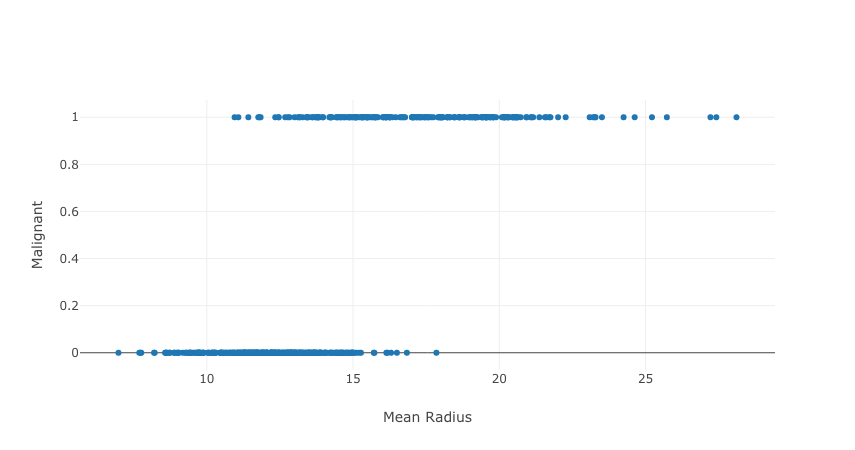

In [4]:
points = go.Scatter(x=data['mean radius'], y = 1.*data['malignant'], mode="markers")
layout = dict(xaxis=dict(title="Mean Radius"),yaxis=dict(title="Malignant"))
py.iplot(go.Figure(data=[points], layout=layout))

This is a clear example of over-plotting.  We can improve the above plot by jittering the data:

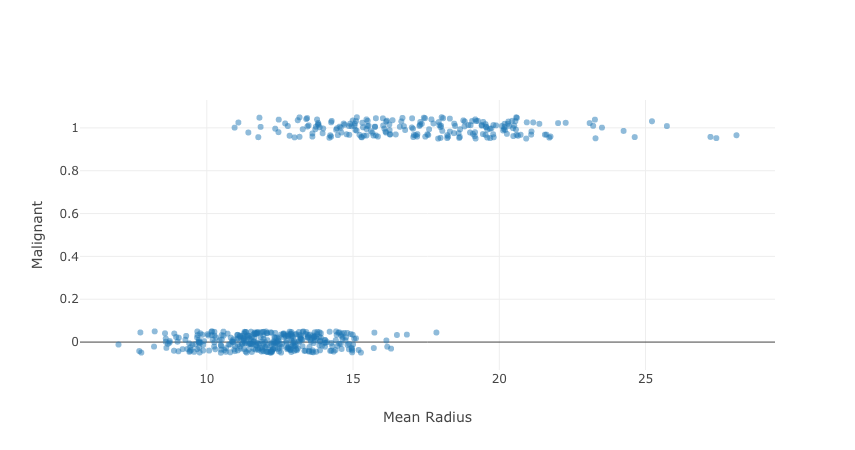

In [5]:
jitter_y = data['malignant'] + 0.1 * np.random.rand(data['malignant'].size) -0.05
points = go.Scatter(x=data['mean radius'], y = jitter_y, 
                    mode="markers", 
                    marker=dict(opacity=0.5))
py.iplot(go.Figure(data=[points], layout=layout))

Perhaps a better way to visualize the data is using stacked histograms.

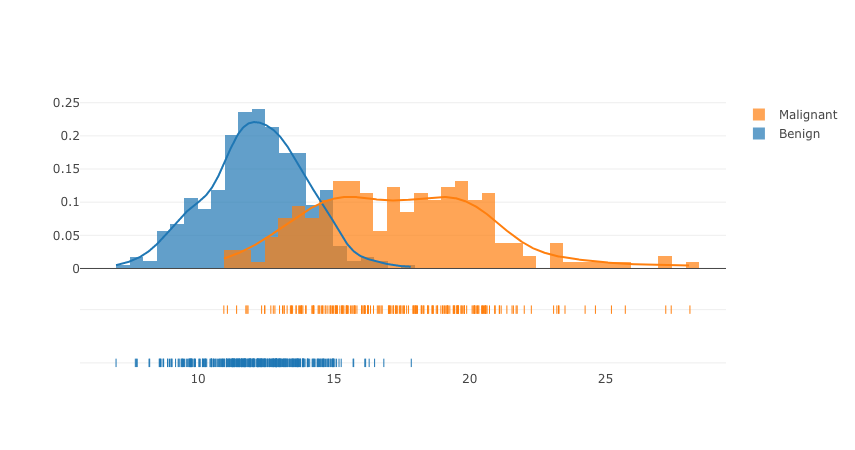

In [6]:
py.iplot(ff.create_distplot(
    [data.loc[~data['malignant'], 'mean radius'],
     data.loc[data['malignant'], 'mean radius']], 
    group_labels=["Benign","Malignant"],
    bin_size=0.5))

**Question:** Looking at the above histograms could you describe a rule to predict whether or a cell is malignant?

---

<br/><br/><br/><br/><br/><br/><br/>

# Least Squares Regression

_"I suppose it is tempting, if the only tool you have is a hammer, to treat everything as if it were a nail."_ -  Abraham Maslow The Psychology of Science

**Goal:** We would like to predict whether the tumor is malignant from the size of the tumor.

Always split your data into training and test groups.  

## Preparing the data Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
data_tr, data_te = train_test_split(data, test_size=0.25, random_state=42)
print("Training Data Size: ", len(data_tr))
print("Test Data Size: ", len(data_te))

Training Data Size:  426
Test Data Size:  143


We will define $X$ and $Y$ as variables containing the training features and labels.

In [8]:
X = data_tr[['mean radius']].values
Y = data_tr['malignant'].values.astype('float')

Fit a least squares regression model.

In [9]:
import sklearn.linear_model as linear_model

least_squares_model = linear_model.LinearRegression()
least_squares_model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# How is our fit?

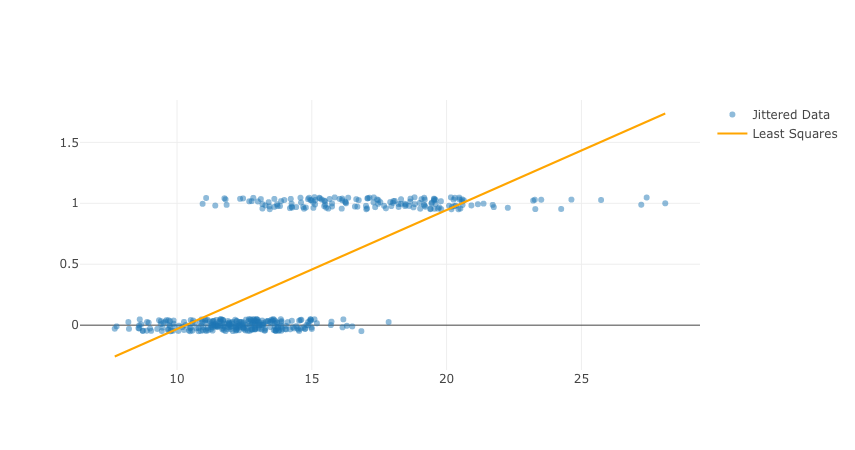

In [10]:
jitter_y = Y + 0.1*np.random.rand(len(Y)) - 0.05
points = go.Scatter(name="Jittered Data", 
                    x=np.squeeze(X), y = jitter_y, 
                    mode="markers", marker=dict(opacity=0.5))
X_plt = np.linspace(np.min(X), np.max(X), 10)
model_line = go.Scatter(name="Least Squares",
    x=X_plt, y=least_squares_model.predict(X_plt[:,np.newaxis]), 
    mode="lines", line=dict(color="orange"))
py.iplot([points, model_line])

# Questions:

1. Are we happy with the fit?
2. What is the meaning of predictions that are neither 0 or 1?
3. Could we use this to make a decision?

---
<br/><br/><br/><br/><br/>

# What is the Root Mean Squared Error?

In [11]:
from sklearn.metrics import mean_squared_error as mse
print("Training RMSE:", np.sqrt(mse(Y, least_squares_model.predict(X))))

Training RMSE: 0.338350570943863


What does that mean for this data?

---
<br/><br/><br/><br/><br/><br/>

# Classification Error

This is a classification problem so we probably want to measure how often we predict the correct value.  This is sometimes called the zero-one loss (or error):

$$ \large
\textbf{ZeroOneLoss} = \frac{1}{n} \sum_{i=1}^n \textbf{I}\left[ y_i \neq f_\theta(x) \right]
$$

However to use the classification error we need to define a decision rule that maps $f_\theta(x)$ to the $\{0,1\}$ classification values.

---
<br/><br/><br/><br/><br/>

# Simple Decision Rule

Suppose we instituted the following simple decision rule:

$$\Large
\text{If } f_\theta(x) > 0.5  \text{ predict 1 (malignant) else predict 0 (benign).}
$$

This simple **decision rule** is deciding that a tumor is malignant if our model predicts a values above 0.5 (closer to 1 than zero).

In the following we plot the implication of these decisions on our training data.

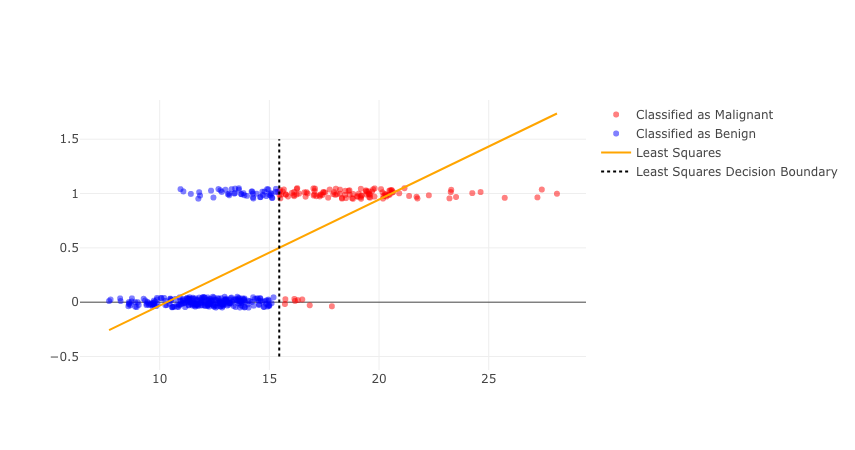

In [12]:
jitter_y = Y + 0.1*np.random.rand(len(Y)) - 0.05
ind_mal = least_squares_model.predict(X) > 0.5

mal_points = go.Scatter(name="Classified as Malignant", 
                    x=np.squeeze(X[ind_mal]), y = jitter_y[ind_mal], 
                    mode="markers", marker=dict(opacity=0.5, color="red"))
ben_points = go.Scatter(name="Classified as Benign", 
                    x=np.squeeze(X[~ind_mal]), y = jitter_y[~ind_mal], 
                    mode="markers", marker=dict(opacity=0.5, color="blue"))
dec_boundary = (0.5 - least_squares_model.intercept_)/least_squares_model.coef_[0]
dec_line = go.Scatter(name="Least Squares Decision Boundary", 
                      x = [dec_boundary,dec_boundary], y=[-0.5,1.5], mode="lines",
                     line=dict(color="black", dash="dot"))
py.iplot([mal_points, ben_points, model_line,dec_line])

# Compute `ZeroOneLoss`

In [13]:
from sklearn.metrics import zero_one_loss
print("Training Fraction incorrect:", 
      zero_one_loss(Y, least_squares_model.predict(X) > 0.5))

Training Fraction incorrect: 0.1338028169014085


**Questions** 

1. Are we happy with this error level?
1. What error would we get if we just guessed the label?

---
<br/><br/><br/><br/><br/><br/>


# Guessing the Majority Class

This is the simplest baseline we could imagine and one you should always compare against.  Let's start by asking what is the majority class

In [14]:
print("Fraction of Malignant Samples:", np.mean(Y))

Fraction of Malignant Samples: 0.37089201877934275


Therefore if we guess the majority class **benign** we would get what accuracy?

In [15]:
# You can figure this out from the above number
print("Guess Majority:",  zero_one_loss(Y, np.zeros(len(Y))))

Guess Majority: 0.37089201877934275


This is standard example of a common problem in classification (and perhaps modern society): **class imbalance**.

# Class Imbalance


Class imbalance is when a disproportionate fraction of the samples are in one class (in this case benign).  In extreme cases (e.g., fraud detection) only tiny fraction of the training data may contain examples in particular class.  In these settings we can achieve very high-accuracies by always predicting the frequent class without learning a good classifier for the rare classes. 




## Addressing Class Imbalance

There are many techniques for managing class imbalance here are a few:

1. Re-sample data to reduce or eliminate the class imbalance.
2. Try learning algorithm that are a little more robust to class imbalance (e.g., decisions trees).
3. Adjust the loss function to put a larger penalty on the smaller class.

In this example the class imbalance is not that extreme so we will continue without re-sampling.



<br/><br/><br/>

# Cross Validation of Zero-One Error

In the following we compute the cross validation error.

In [16]:
from sklearn.model_selection import KFold
kfold = KFold(3,shuffle=True, random_state=42)
linreg_errors = []
models = []

for tr_ind, te_ind in kfold.split(X):
    model = linear_model.LinearRegression()
    model.fit(X[tr_ind,], Y[tr_ind])
    models.append(model)
    linreg_errors.append(zero_one_loss(Y[te_ind], model.predict(X[te_ind,]) > 0.5))
    
print("Min Validation Error:   ", np.min(linreg_errors))
print("Median Validation Error:", np.median(linreg_errors))
print("Max Validation Error:   ", np.max(linreg_errors))

Min Validation Error:    0.08450704225352113
Median Validation Error: 0.1619718309859155
Max Validation Error:    0.176056338028169


We can visualize all the models and their decisions

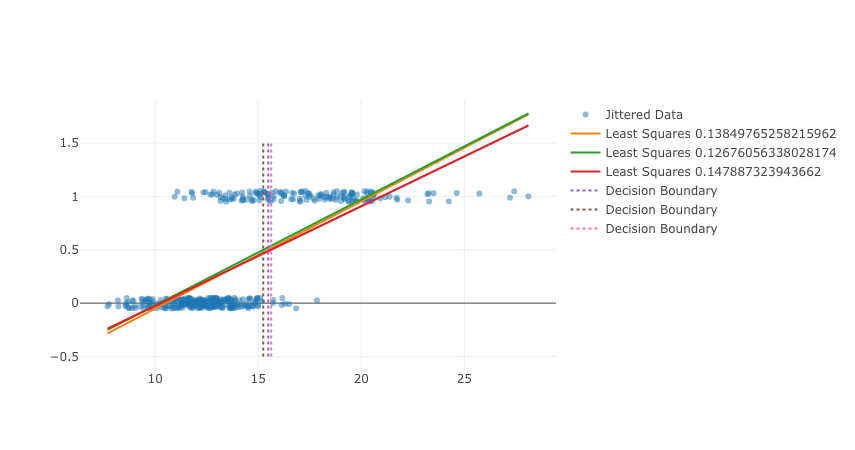

In [17]:
dec_lines = [
    go.Scatter(name="Decision Boundary", 
               x = [(0.5 - m.intercept_)/m.coef_[0]]*2, 
               y=[-0.5,1.5], mode="lines",
               line=dict(dash="dot"))
    for m in models]

X_plt = np.linspace(np.min(X), np.max(X), 10)
model_lines = [
    go.Scatter(name="Least Squares " + str(zero_one_loss(Y, m.predict(X) > 0.5)),
               x=X_plt, y=m.predict(np.array([X_plt]).T), 
               mode="lines")
    for m in models]
py.iplot([points] + model_lines + dec_lines)



# Can we think of the line as a _"probability"_?


Not really.  Probabilities are constrained between 0 and 1.   How could we learn a model that captures this probabilistic interpretation?



# Could we just truncate the line?

Maybe we can define the probability as:

$$ \large
p_i = \min\left(\max \left( x^T \theta , 0 \right), 1\right)
$$

this would look like:

In [18]:
def bound01(z):
    u = np.where(z > 1, 1, z)
    return np.where(u < 0, 0, u)

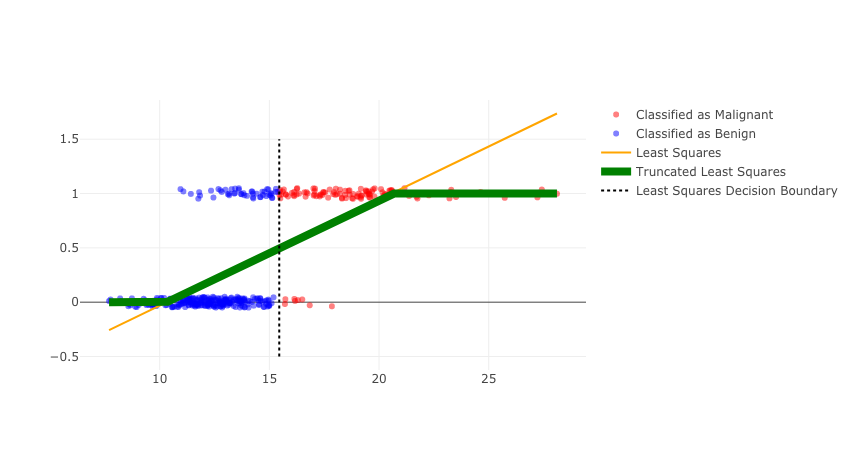

In [19]:
X_plt = np.linspace(np.min(X), np.max(X), 100)
p_line = go.Scatter(name="Truncated Least Squares",
    x=X_plt, y=bound01(least_squares_model.predict(np.array([X_plt]).T)), 
    mode="lines", line=dict(color="green", width=8))
py.iplot([mal_points, ben_points, model_line, p_line, dec_line], filename="lr-06")

So far least squares regression seems pretty reasonable and we can "force" the predicted values to be bounded between 0 and 1.  

**Can we interpret the truncated values as probabilities?** 

Perhaps, but it would depend on how the model is estimated (more on this soon).




# An Issue with Extreme Points 

It seems like large tumor sizes are indicative of malignant tumors.  Suppose we observed a very large malignant tumor that is 100mm in mean radius.  What would this do to our model?


Let's add an extra data point and see what happens:

In [20]:
X_ex = np.vstack([X, [100]])
Y_ex = np.hstack([Y, 1.])
least_squares_model_ex = linear_model.LinearRegression()
least_squares_model_ex.fit(X_ex, Y_ex)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

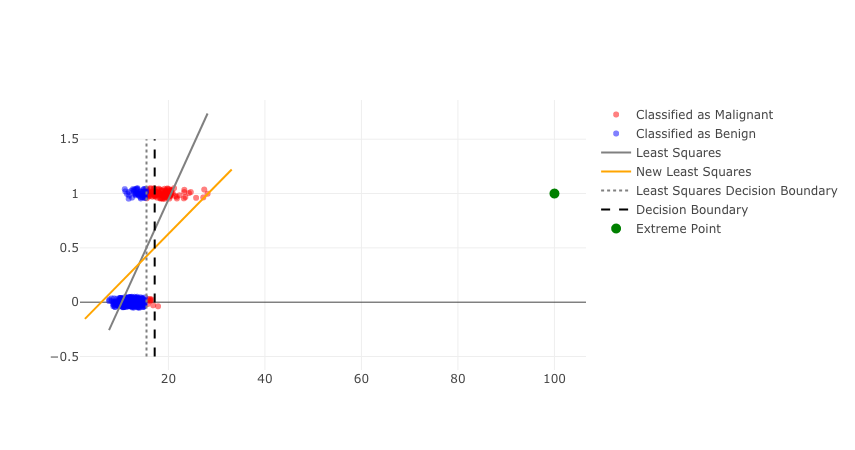

In [21]:
X_plt = np.linspace(np.min(X)-5, np.max(X)+5, 100)

extreme_point = go.Scatter(
    name="Extreme Point", x=[100], y=[1], mode="markers", 
    marker=dict(color="green", size=10))
model_line.line.color = "gray"
model_line_ex = go.Scatter(name="New Least Squares",
    x=X_plt, y=least_squares_model_ex.predict(np.array([X_plt]).T), 
    mode="lines", line=dict(color="orange"))

dec_line.line.color = "gray"

dec_boundary_ex = (0.5 - least_squares_model_ex.intercept_)/least_squares_model_ex.coef_[0]
dec_line_ex = go.Scatter(
    name="Decision Boundary", 
    x = [dec_boundary_ex, dec_boundary_ex], y=[-0.5,1.5], mode="lines",
    line=dict(color="black", dash="dash"))



py.iplot([mal_points, ben_points,model_line, model_line_ex, dec_line, dec_line_ex, extreme_point])

## Observing the resulting RMSE

In [22]:
print("Before:", 
      zero_one_loss(Y_ex, least_squares_model.predict(X_ex) > 0.5))
print("After:", 
      zero_one_loss(Y_ex, least_squares_model_ex.predict(X_ex) > 0.5))

Before: 0.13348946135831385
After: 0.18266978922716626
